# Moving Digit Direction Classification Evolution Engine

In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import random

# imports
from snntorch import LIF
from snntorch import functional

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

from numpy import load

import sys
import os

from warnings import warn
from snntorch.surrogate import atan

import pandas as pd
from copy import deepcopy
import random
import seaborn as sns

#### Movement Dataset Class

In [49]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler


df = pd.read_csv('movement_sequences.csv')
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [51]:
class MovementSequenceDataset(Dataset):
    def __init__(self, df):
        self.data = df
        self.num_frames = 100

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        frames = []
        for i in range(self.num_frames):
            frame = json.loads(self.data.iloc[idx, i])
            flattened_frame = np.array(frame).flatten()
            frames.append(flattened_frame)
        frames = np.array(frames)
        direction = self.data.iloc[idx, self.num_frames]
        direction_label = self.direction_to_label(direction)

        return torch.tensor(frames, dtype=torch.float32), torch.tensor(direction_label, dtype=torch.long)

    def direction_to_label(self, direction):
        direction_mapping = {'up': 0, 'down': 1, 'left': 2, 'right': 3}
        return direction_mapping[direction]

train_dataset = MovementSequenceDataset(train_df)
test_dataset = MovementSequenceDataset(test_df)

train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=False)

for inputs, labels in train_dataloader:
    print("Input batch shape:", inputs.shape)
    print("Labels batch shape:", labels.shape)
    print("First input example:", inputs[0][0])
    break

Input batch shape: torch.Size([100, 100, 36])
Labels batch shape: torch.Size([100])
First input example: tensor([  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   1., 200.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.])


In [52]:
def plot_spike_tensor(spk_tensor, title):
    # Generate the plot
    spk_tensor = spk_tensor.T
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot spikes
    splt.raster(spk_tensor, ax, s=0.5, c="black")  # Transpose to align with neurons on y-axis

    # Set labels and title
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Neuron")
    ax.set_title(title)

    plt.show()

def simple_branching_param(bin_size, spikes):  # spikes in shape of [units, time]
    run_time = spikes.shape[1]
    nbins = spikes.shape[1]
    # nbins = int(np.round(run_time / bin_size))
    # for every pair of timesteps, determine the number of ancestors
    # and the number of descendants
    numA = torch.zeros(nbins - 1)
    # number of ancestors for each bin
    numD = torch.zeros(nbins - 1)
    # number of descendants for each ancestral bin
    i = 0
    while i < (numA.size(0) - 1):
        numA[i] = torch.sum(spikes[:, i] == 1).item()
        numD[i] = torch.sum(spikes[:, i + bin_size] == 1).item()
        # Check if numA[i] is 0, and remove numA[i] and numD[i] if it is
        if numA[i] == 0:
            numA = torch.cat((numA[:i], numA[i+1:]))
            numD = torch.cat((numD[:i], numD[i+1:]))
        else:
            i+=1
    # the ratio of descendants per ancestor
    d = numD / numA
    bscore = torch.nanmean(d)
    return bscore


# Synchrony -- Fano Factor
def fano_factor(seq_len, spike):
    # Calculate value similar to the Fano factor to estimate synchrony quickly
    # During each bin, calculate the variance of the number of spikes per neuron divided by the mean of the number of spikes per neuron
    # The Fano factor during one interval is equal to the mean of the values calculated for each bin in it
    # Spike should have dims of neuron, time
    # Returned fano factor should have dims of trial
    len_bins = 10  # ms
    n_bins = int(round(seq_len / len_bins))
    fano_all = torch.zeros(n_bins)
    for i in range(n_bins):
        spike_slice = spike[:, i * len_bins:(i + 1) * len_bins]
        spikes_per_neuron = torch.sum(spike_slice, axis=1)
        variance_spikes = torch.var(spikes_per_neuron)
        mean_spikes = torch.mean(spikes_per_neuron)
        fano_bin = variance_spikes / mean_spikes if mean_spikes != 0 else 0
        fano_all[i] = fano_bin
    n_fano = torch.mean(fano_all)
    return n_fano


### Building Connectivity and Neurons

In [53]:
def conn_mx(rows, columns, sparseness):
    # Calculate the number of non-zero entries based on sparseness
    num_non_zero_entries = int(rows * columns * sparseness)

    # Initialize the matrix with zeros
    conn_mx = torch.zeros(rows, columns)

    # Randomly select indices to set to the specified value
    indices = torch.randperm(rows * columns)[:num_non_zero_entries]

    # Initialize non-zero values using log normal distribution
    mu = -0.64
    sigma = 0.51
    log_normal_values = torch.empty(indices.shape).normal_(mean=mu, std=sigma).exp_()
    conn_mx.view(-1)[indices] = log_normal_values

    return conn_mx

# creates an excitatory and inhibitory matrix
def hid_mx(rows, columns, num_excitatory, num_inhibitory):
    # hard coded sparsity

    # Initialize the weight matrix
    weight_matrix = np.zeros((num_excitatory + num_inhibitory, num_excitatory + num_inhibitory))

    # Set excitatory to excitatory connections
    weight_matrix[:num_excitatory, :num_excitatory] = np.random.choice([0, 1], size=(num_excitatory, num_excitatory), p=[1-0.16, 0.16])

    # Set excitatory to inhibitory connections
    weight_matrix[:num_excitatory, num_excitatory:] = np.random.choice([0, 1], size=(num_excitatory, num_inhibitory), p=[1-0.205, 0.205])

    # Set inhibitory to excitatory connections
    weight_matrix[num_excitatory:, :num_excitatory] = np.random.choice([0, -1], size=(num_inhibitory, num_excitatory),p=[1-0.252, 0.252])

    # Set inhibitory to inhibitory connections
    weight_matrix[num_excitatory:, num_excitatory:] = np.random.choice([0, -1], size=(num_inhibitory, num_inhibitory), p=[1-0.284, 0.284] )

    # Initialize non-zero values using log normal distribution
    mu = -0.64
    sigma = 0.51
    non_zero_indices = np.where(weight_matrix != 0)
    weight_matrix[non_zero_indices] = np.random.lognormal(mean=mu, sigma=sigma, size=non_zero_indices[0].shape)

    # Multiply the last num_inhibitory rows by -10
    weight_matrix[-num_inhibitory:, :] *= -10

    return torch.tensor(weight_matrix.astype(np.float32))

In [ ]:
# leaky integrate-and-fire neuron with recurrent connections from snn torch with refractory period
# currently not implemented with direction task for consistency with BPTT training

class RLIF1(LIF):
    def __init__(
        self,
        beta,
        V=1.0,
        all_to_all=True,
        linear_features=None,
        conv2d_channels=None,
        kernel_size=None,
        threshold=-55.0,  # Changed threshold to -55 mV
        spike_grad=None,
        surrogate_disable=False,
        init_hidden=False,
        inhibition=False,
        learn_beta=False,
        learn_threshold=False,
        learn_recurrent=True,
        reset_mechanism="zero",
        state_quant=False,
        output=False,
        reset_delay=True,
        refractory_period=5, # Refractory period of 5 timesteps
    ):
        super().__init__(
            beta,
            threshold,
            spike_grad,
            surrogate_disable,
            init_hidden,
            inhibition,
            learn_beta,
            learn_threshold,
            reset_mechanism,
            state_quant,
            output,
        )

        self.all_to_all = all_to_all
        self.learn_recurrent = learn_recurrent

        # linear params
        self.linear_features = linear_features

        # Conv2d params
        self.kernel_size = kernel_size
        self.conv2d_channels = conv2d_channels

        # catch cases
        self._rleaky_init_cases()

        # initialize recurrent connections
        if self.all_to_all:
            self._init_recurrent_net()
        else:
            self._V_register_buffer(V, learn_recurrent)
            self._init_recurrent_one_to_one()

        if not learn_recurrent:
            self._disable_recurrent_grad()

        self._init_mem()

        if self.reset_mechanism_val == 0:
            self.state_function = self._base_sub
        elif self.reset_mechanism_val == 1:
            self.state_function = self._base_zero
        elif self.reset_mechanism_val == 2:
            self.state_function = self._base_int

        self.reset_delay = reset_delay

        # Refractory period in timesteps
        self.refractory_period = refractory_period

    def _init_mem(self):
        spk = torch.zeros(0)
        mem = torch.zeros(0)
        refractory_counter = torch.zeros(0)

        self.register_buffer("spk", spk, False)
        self.register_buffer("mem", mem, False)
        self.register_buffer("refractory_counter", refractory_counter, persistent=False)

    def reset_mem(self):
        self.spk = torch.zeros_like(self.spk, device=self.spk.device)
        # Initialize the membrane potential with a normal distribution (mean=0, std=1)
        self.mem = torch.randn_like(self.mem, device=self.mem.device)
        self.refractory_counter = torch.zeros_like(self.refractory_counter, device=self.refractory_counter.device)
        return self.spk, self.mem

    def init_rleaky(self):
        return self.reset_mem()

    def forward(self, input_, spk=None, mem=None, refractory_counter=None):
        if not spk is None:
            self.spk = spk

        if not mem is None:
            self.mem = mem

        if not refractory_counter is None:
            self.refractory_counter = refractory_counter

        if self.init_hidden and (not mem is None or not spk is None or not refractory_counter is None):
            raise TypeError(
                "When `init_hidden=True`, RLeaky expects 1 input argument."
            )

        if not self.spk.shape == input_.shape:
            self.spk = torch.zeros_like(input_, device=self.spk.device)

        if not self.mem.shape == input_.shape:
            self.mem = torch.randn_like(input_, device=self.mem.device)

        if not self.refractory_counter.shape == input_.shape:
            self.refractory_counter = torch.zeros_like(input_, device=self.refractory_counter.device)

        # With each forward, decrement the counter
        self.refractory_counter = torch.clamp(self.refractory_counter - 1, min=0)

        # Update the membrane potential
        self.reset = self.mem_reset(self.mem)
        self.mem = self.state_function(input_)

        # Set a spike on when refractory period is 0
        refractory_mask = (self.refractory_counter == 0)
        self.spk = self.fire(self.mem) * refractory_mask

        # Update the refractory counter back to 5 where spikes occurred
        self.refractory_counter[self.spk > 0] = self.refractory_period

        if not self.reset_delay:
            do_reset = (
                self.spk / self.graded_spikes_factor - self.reset
            )
            if self.reset_mechanism_val == 0:
                self.mem = self.mem - do_reset * self.threshold
            elif self.reset_mechanism_val == 1:
                self.mem = self.mem - do_reset * self.mem

        if self.output:
            return self.spk, self.mem
        elif self.init_hidden:
            return self.spk
        else:
            return self.spk, self.mem

    def _init_recurrent_net(self):
        if self.all_to_all:
            if self.linear_features:
                self._init_recurrent_linear()
            elif self.kernel_size is not None:
                self._init_recurrent_conv2d()
        else:
            self._init_recurrent_one_to_one()

    def _init_recurrent_linear(self):
        self.recurrent = nn.Linear(self.linear_features, self.linear_features)

    def _init_recurrent_conv2d(self):
        self._init_padding()
        self.recurrent = nn.Conv2d(
            in_channels=self.conv2d_channels,
            out_channels=self.conv2d_channels,
            kernel_size=self.kernel_size,
            padding=self.padding,
        )

    def _init_padding(self):
        if type(self.kernel_size) is int:
            self.padding = self.kernel_size // 2, self.kernel_size // 2
        else:
            self.padding = self.kernel_size[0] // 2, self.kernel_size[1] // 2

    def _init_recurrent_one_to_one(self):
        self.recurrent = RecurrentOneToOne(self.V)

    def _disable_recurrent_grad(self):
        for param in self.recurrent.parameters():
            param.requires_grad = False

    def _base_state_function(self, input_):
        # Adjusting beta to decay towards -70 mV
        base_fn = (
            self.beta.clamp(0, 1) * (self.mem + 70) + input_ + self.recurrent(self.spk) - 70
        )
        return base_fn

    def _base_sub(self, input_):
        return self._base_state_function(input_) - self.reset * self.threshold

    def _base_zero(self, input_):
        return self._base_state_function(input_) - self.reset * self._base_state_function(input_)

    def _base_int(self, input_):
        return self._base_state_function(input_)

    def _rleaky_init_cases(self):
        all_to_all_bool = bool(self.all_to_all)
        linear_features_bool = self.linear_features
        conv2d_channels_bool = bool(self.conv2d_channels)
        kernel_size_bool = bool(self.kernel_size)

        if all_to_all_bool:
            if not (linear_features_bool):
                if not (conv2d_channels_bool or kernel_size_bool):
                    raise TypeError(
                        "When `all_to_all=True`, RLeaky requires either"
                        "`linear_features` or (`conv2d_channels` and "
                        "`kernel_size`) to be specified. The "
                        "shape should match the shape of the output spike of "
                        "the layer."
                    )
                elif conv2d_channels_bool ^ kernel_size_bool:
                    raise TypeError(
                        "`conv2d_channels` and `kernel_size` must both be"
                        "specified. The shape of `conv2d_channels` should "
                        "match the shape of the output"
                        "spikes."
                    )
            elif (linear_features_bool and kernel_size_bool) or (
                linear_features_bool and conv2d_channels_bool
            ):
                raise TypeError(
                    "`linear_features` cannot be specified at the same time as"
                    "`conv2d_channels` or `kernel_size`. A linear layer and "
                    "conv2d layer cannot both"
                    "be specified at the same time."
                )
        else:
            if (
                linear_features_bool
                or conv2d_channels_bool
                or kernel_size_bool
            ):
                raise TypeError(
                    "When `all_to_all`=False, none of `linear_features`,"
                    "`conv2d_channels`, or `kernel_size` should be specified. "
                    "The weight `V` is used"
                    "instead."
                )

    @classmethod
    def detach_hidden(cls):
        for layer in range(len(cls.instances)):
            if isinstance(cls.instances[layer], RLIF1):
                cls.instances[layer].mem.detach_()
                cls.instances[layer].spk.detach_()

    @classmethod
    def reset_hidden(cls):
        for layer in range(len(cls.instances)):
            if isinstance(cls.instances[layer], RLIF1):
                (
                    cls.instances[layer].spk,
                    cls.instances[layer].mem,
                ) = cls.instances

### Defining the Network

In [54]:
# Custom Loss function with classification,continuous, and firing rate losses
class CustomLoss(nn.Module):
    def __init__(self,  target_firing_rate=0.02):
        super(CustomLoss, self).__init__()
        self.target_firing_rate = torch.tensor(target_firing_rate, requires_grad=False)
        self.criterion_classification = nn.CrossEntropyLoss()
        self.criterion_continuous = nn.MSELoss()

    def forward(self, outputs, targets, firing_rate):
        batch_size = targets.size(0)
        
        # Classification loss
        classification_loss = self.criterion_classification(outputs, targets)
        
        # Continuous losses
        rate_loss = self.criterion_continuous(firing_rate, self.target_firing_rate.expand_as(firing_rate))
        
        # Weight the losses
        w_classification = 3
        w_rate = 0

        total_loss = (
            w_classification * classification_loss +
            w_rate * rate_loss)

        return total_loss


In [55]:
# RSNN model with 36 input neurons, 256 hidden neurons, and 4 output neurons
class RSNN_direction(nn.Module):
    def __init__(self):
        super(RSNN_direction, self).__init__()
        num_inputs = 36
        num_hidden = 256
        num_output = 4
        beta = 0.85
        pe_e = 0.16

        # Define the dimensions
        num_excitatory = 192
        self.num_excitatory = num_excitatory
        num_inhibitory = num_hidden - num_excitatory
        self.false_neg = []
        self.false_pos = []

        #input to hidden layer
        input_hid_mx = conn_mx(num_inputs, num_hidden, pe_e)
        self.input_hid_mx = input_hid_mx
        self.l1 = nn.Linear(num_inputs,num_hidden)
        init.kaiming_uniform_(self.l1.weight)
        self.l1.weight.data = input_hid_mx.T

        # Recurrent layer weight matrix
        hidden_mx = hid_mx(num_hidden,num_hidden,num_excitatory,num_inhibitory)
        self.rlif1 = snn.RLeaky(reset_mechanism="zero",threshold=10, beta=beta, linear_features=num_hidden, all_to_all=True)
        self.rlif1.recurrent.weight.data = hidden_mx.T

        # hidden to output layer
        hid_out_mx = conn_mx(num_hidden,num_output,pe_e)
        self.l2 = nn.Linear(num_hidden, num_output)
        init.kaiming_uniform_(self.l2.weight)
        self.l2.weight.data = hid_out_mx.T


    def forward(self, inputs):
        spk1,mem1 = self.rlif1.init_rleaky()
        self.spk1_rec = []
        self.cur2_rec = []

        # print(inputs.shape)
        for step in range(inputs.shape[0]):
            cur_input = inputs[step,:]
            cur1 = self.l1(cur_input)
            spk1,mem1 = self.rlif1(cur1, spk1, mem1)
            cur2 = self.l2(spk1)

            self.spk1_rec.append(spk1)
            self.cur2_rec.append(cur2)

        self.spk1_rec = torch.stack(self.spk1_rec)
        self.cur2_rec = torch.stack(self.cur2_rec)
        cur2_rec = self.cur2_rec.mean(dim=0)  # Average over timesteps
        # print("Shape of cur2_rec before softmax:", cur2_rec.shape)

        output = nn.functional.softmax(cur2_rec, dim=-1)  # Apply softmax

        return output, self.spk1_rec

    def positive_negative_weights(self):

        excitatory_weights = self.rlif1.recurrent.weight.data[:, :self.num_excitatory]
        inhibitory_weights = self.rlif1.recurrent.weight.data[:, self.num_excitatory:]

        #save the number of positives in inhibitory and negatives in excitatory region
        num_false_neg = torch.sum(excitatory_weights < 0).item()
        num_false_pos = torch.sum(inhibitory_weights > 0).item()

        self.false_neg.append(num_false_neg)
        self.false_pos.append(num_false_pos)

        # Clamp switched sign values at 0
        excitatory_weights.clamp_(min=0)
        inhibitory_weights.clamp_(max=0)

        mu = -0.64
        sigma = 0.51


        #change the code so that for any vanishing excitatory neuron, populate another excitatory.

        #following code picks random indices from excitatory and inhibitory originating weights
        #for the number of num_false_neg and num_false_neg for inhibitory and excitatory originating weights respectively
        #assigns them with the lognormal dist
        excitatory_zero_indices = (self.rlif1.recurrent.weight.data[:, :self.num_excitatory] == 0).nonzero(as_tuple=True)
        inhibitory_zero_indices = (self.rlif1.recurrent.weight.data[:, self.num_excitatory:] == 0).nonzero(as_tuple=True)

        if (len(excitatory_zero_indices) > num_false_pos):
            excitatory_sampled_indices = torch.stack([
                    excitatory_zero_indices[0][torch.randint(len(excitatory_zero_indices[0]), (num_false_pos,))],
                    excitatory_zero_indices[1][torch.randint(len(excitatory_zero_indices[1]), (num_false_pos,))]
                ], dim=1)

            # generating self.excitatory_changes number of lognormal values
            new_excitatory_values = torch.from_numpy(np.random.lognormal(mean=mu, sigma=sigma, size=num_false_pos)).float()
            self.rlif1.recurrent.weight.data[excitatory_sampled_indices[:, 0], excitatory_sampled_indices[:, 1]] = new_excitatory_values

        if (len(inhibitory_zero_indices) > num_false_neg):
            inhibitory_sampled_indices = torch.stack([
                    inhibitory_zero_indices[0][torch.randint(len(inhibitory_zero_indices[0]), (num_false_neg,))],
                    inhibitory_zero_indices[1][torch.randint(len(inhibitory_zero_indices[1]), (num_false_neg,))]
                ], dim=1)

            new_inhibitory_values = -torch.from_numpy(np.random.lognormal(mean=mu, sigma=sigma, size=num_false_neg)).float()
            self.rlif1.recurrent.weight.data[inhibitory_sampled_indices[:, 0], self.num_excitatory + inhibitory_sampled_indices[:, 1]] = new_inhibitory_values


### Evolution

In [56]:
# Genetic Encoding and Decoding

# converts model to gene format by concatenating all the parameters
def encode_model(model):
    gene = []
    for param in model.parameters():
        gene.append(param.data.cpu().numpy().flatten())
    gene = np.concatenate(gene)
    return gene

# decodes gene to model format by reshaping the gene to the original parameter shapes
def decode_model(model, gene):
    current_index = 0
    new_model = deepcopy(model)
    for param in new_model.parameters():
        param_shape = param.data.cpu().numpy().shape
        param_size = np.prod(param_shape)
        param.data = torch.tensor(gene[current_index:current_index + param_size].reshape(param_shape))
        current_index += param_size
    return new_model

In [ ]:
device = torch.device("cuda" if (torch.cuda.is_available() and cuda) else "cpu")

criterion = nn.CrossEntropyLoss()
model = RSNN_direction()

Generation 1/20, Best Fitness: 1.369296908378601
Overall Best Fitness: 1.369296908378601
Generation 2/20, Best Fitness: 1.3447563648223877
Overall Best Fitness: 1.3447563648223877
Generation 3/20, Best Fitness: 1.3410582542419434
Overall Best Fitness: 1.3410582542419434
Generation 4/20, Best Fitness: 1.3407577276229858
Overall Best Fitness: 1.3407577276229858
Generation 5/20, Best Fitness: 1.3301423788070679
Overall Best Fitness: 1.3301423788070679
Generation 6/20, Best Fitness: 1.3140608072280884
Overall Best Fitness: 1.3140608072280884
Generation 7/20, Best Fitness: 1.3089203834533691
Overall Best Fitness: 1.3089203834533691
Generation 8/20, Best Fitness: 1.2813421487808228
Overall Best Fitness: 1.2813421487808228
Generation 9/20, Best Fitness: 1.2926689386367798
Overall Best Fitness: 1.2813421487808228
Generation 10/20, Best Fitness: 1.2997713088989258
Overall Best Fitness: 1.2813421487808228
Generation 11/20, Best Fitness: 1.30027174949646
Overall Best Fitness: 1.2813421487808228
G

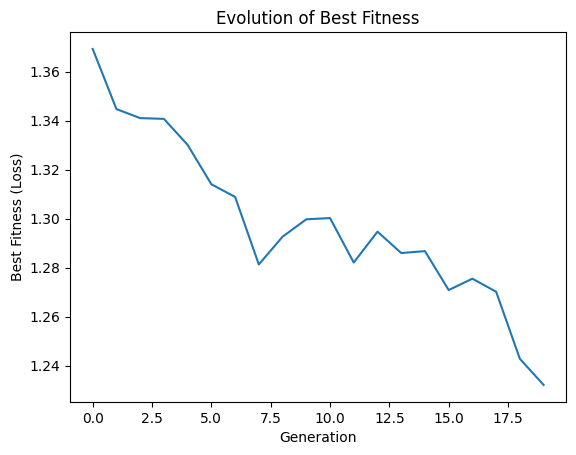

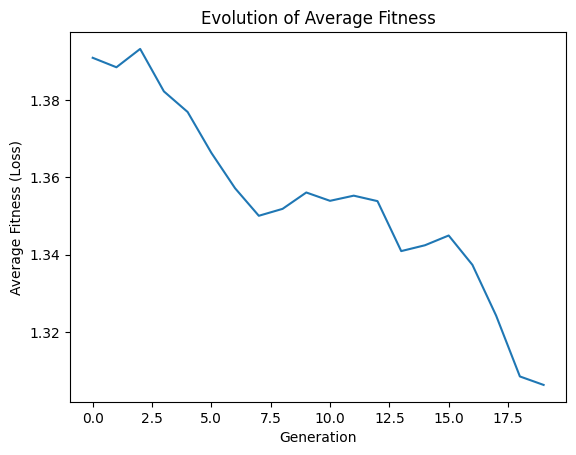

In [57]:
# Main Evolution class

class Evolution(object):
    def __init__(self, model_class, model_args, model_kwargs):
        # Initialize the model class and its arguments
        self.model_class = model_class
        self.model_args = model_args
        self.model_kwargs = model_kwargs


    # Initialize the first population of models
    def populate(self, n_models):
        models = []
        for _ in range(n_models):
            model = self.model_class(*self.model_args, **self.model_kwargs)
            self.initialize_weights(model)
            # Freeze the weights
            for param in model.parameters():
                param.requires_grad = False
            models.append(model)
        return models

    # Initialize the weights of the model with the specified connectivity
    def initialize_weights(self, model):
        num_inputs = model.l1.in_features
        num_hidden = model.l1.out_features
        num_output = model.l2.out_features
        num_excitatory = model.num_excitatory
        num_inhibitory = num_hidden - num_excitatory
        pe_e = 0.16

        # input to hidden layer
        input_hid_mx = conn_mx(num_inputs, num_hidden, pe_e)
        model.l1.weight.data = input_hid_mx.T

        # Recurrent layer weight matrix
        hidden_mx = hid_mx(num_hidden, num_hidden, num_excitatory, num_inhibitory)
        model.rlif1.recurrent.weight.data = hidden_mx.T

        # hidden to output layer
        hid_out_mx = conn_mx(num_hidden, num_output, pe_e)
        model.l2.weight.data = hid_out_mx.T

        # Store the initial sparsity mask
        self.weights = model.rlif1.recurrent.weight.data
        self.sparse_mask = torch.where(self.weights == 0, 1, 0)
        
    # encode the population of models into genes
    def encode_population(self, models):
        return [encode_model(model) for model in models]

    # decode the genes back into models
    def decode_population(self, genes, template_model):
        return [decode_model(template_model, gene) for gene in genes]

    # evaluate the models in the population
    def evaluate(self, models, dataloader):
        fitness = []
        for model in models:
            loss = self.evaluate_model(model, dataloader)
            fitness.append(loss)
        return fitness

    # evaluate a model on the dataloader
    def evaluate_model(self, model, dataloader):
        running_loss = 0
        model.eval()
        with torch.no_grad():
            for i, (inputs, direction_labels) in enumerate(dataloader):
                outputs = []

                for batch_idx, (input, direction_label) in enumerate(zip(inputs, direction_labels)):
                    output, spikes = model(input)
                    outputs.append(output)

                    firing_rate = torch.sum(spikes) / torch.tensor(spikes.numel(), dtype=torch.float)
                    # synchrony_fano_factor = fano_factor(num_timesteps, spikes)
                    # criticality = simple_branching_param(1, spikes)
                
                outputs = torch.stack(outputs)
                loss = criterion(outputs, direction_labels)
                running_loss += loss.item()
                break
            
        return running_loss

    # select the top k models based on their fitness
    def select(self, genes, fitness, k=2):
        selected_indices = np.argsort(fitness)[:k]
        return [genes[i] for i in selected_indices], [fitness[i] for i in selected_indices]

    # crossover two parents to generate a child
    def crossover(self, parent1, parent2):
        child = deepcopy(parent1)
        crossover_mask = np.random.rand(len(child)) < 0.5
        child[crossover_mask] = parent2[crossover_mask]
        return child


    # mutate the gene with a mutation rate
    def mutate(self, gene, mutation_rate):
        mutation_mask = np.random.rand(len(gene)) < mutation_rate
        gene[mutation_mask] += np.random.randn(np.sum(mutation_mask))

        # Decode the gene to a model format
        model = self.model_class(*self.model_args, **self.model_kwargs)
        decode_model(model, gene)  # Assuming decode_model is a method of the class

        # Reapply the initial sparsity mask
        model_weights = model.rlif1.recurrent.weight.data
        model_weights[self.sparse_mask == True] = 0

        # Split the weights into excitatory and inhibitory
        excitatory_weights = model_weights[:, :model.num_excitatory]
        inhibitory_weights = model_weights[:, model.num_excitatory:]

        # Clamp switched sign values at 0
        excitatory_weights.clamp_(min=0)
        inhibitory_weights.clamp_(max=0)

        # Ensure no neuron vanishes to enforce dale's law
        self.handle_vanishing_neurons(model, excitatory_weights, inhibitory_weights)  # Assuming handle_vanishing_neurons is a method of the class

        return gene
    
    # dale's law implementation to ensure no neuron vanishes
    def handle_vanishing_neurons(self, model, excitatory_weights, inhibitory_weights):
        num_excitatory = model.num_excitatory

        mu = -0.64
        sigma = 0.51

        num_false_neg = torch.sum(excitatory_weights < 0).item()
        num_false_pos = torch.sum(inhibitory_weights > 0).item()

        excitatory_zero_indices = (model.rlif1.recurrent.weight.data[:, :num_excitatory] == 0).nonzero(as_tuple=True)
        inhibitory_zero_indices = (model.rlif1.recurrent.weight.data[:, num_excitatory:] == 0).nonzero(as_tuple=True)

        if len(excitatory_zero_indices[0]) > num_false_pos:
            excitatory_sampled_indices = torch.stack([
                excitatory_zero_indices[0][torch.randint(len(excitatory_zero_indices[0]), (num_false_pos,))],
                excitatory_zero_indices[1][torch.randint(len(excitatory_zero_indices[1]), (num_false_pos,))]
            ], dim=1)

            new_excitatory_values = torch.from_numpy(np.random.lognormal(mean=mu, sigma=sigma, size=num_false_pos)).float()
            model.rlif1.recurrent.weight.data[excitatory_sampled_indices[:, 0], excitatory_sampled_indices[:, 1]] = new_excitatory_values

        if len(inhibitory_zero_indices[0]) > num_false_neg:
            inhibitory_sampled_indices = torch.stack([
                inhibitory_zero_indices[0][torch.randint(len(inhibitory_zero_indices[0]), (num_false_neg,))],
                inhibitory_zero_indices[1][torch.randint(len(inhibitory_zero_indices[1]), (num_false_neg,))]
            ], dim=1)

            new_inhibitory_values = -torch.from_numpy(np.random.lognormal(mean=mu, sigma=sigma, size=num_false_neg)).float()
            model.rlif1.recurrent.weight.data[inhibitory_sampled_indices[:, 0], num_excitatory + inhibitory_sampled_indices[:, 1]] = new_inhibitory_values

    # generate next generation of offspring from the parents
    def generate_offspring(self, parents, n_offspring, mutation_rate):
        offspring = []
        for _ in range(n_offspring):
            parent1, parent2 = random.sample(parents, 2)
            child = self.crossover(parent1, parent2)
            child = self.mutate(child, mutation_rate)
            offspring.append(child)
        return offspring

    # plot the evolution of the best fitness
    def plot_best_fitness(self, all_best_fitness):
        plt.figure()
        plt.plot(all_best_fitness)
        plt.xlabel("Generation")
        plt.ylabel("Best Fitness (Loss)")
        plt.title("Evolution of Best Fitness")
        plt.show()

    # plot the distribution of fitness across generations as a histogram
    def plot_fitness_distribution(self, all_fitness):
        plt.figure()
        num_generations = len(all_fitness)
        cmap = plt.get_cmap("viridis", num_generations)  # Use the viridis colormap

        for i, fitness in enumerate(all_fitness):
            plt.hist(fitness, bins=30, alpha=0.5, label=f'Gen {i+1}', color=cmap(i / num_generations))

        norm = plt.Normalize(vmin=1, vmax=num_generations)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        cbar = plt.colorbar(sm, ticks=np.linspace(1, num_generations, num_generations))
        cbar.set_label('Generation')

        plt.xlabel("Fitness (Loss)")
        plt.ylabel("Frequency")
        plt.title("Fitness Distribution Across Generations")
        plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))
        plt.show()

    # plot the evolution of the average fitness
    def plot_average_fitness(self, all_fitness):
        average_fitness = [np.mean(fitness) for fitness in all_fitness]
        plt.figure()
        plt.plot(average_fitness)
        plt.xlabel("Generation")
        plt.ylabel("Average Fitness (Loss)")
        plt.title("Evolution of Average Fitness")
        plt.show()

    # run the evolutionary process
    def evolve(self, n_models, n_offspring, n_generations, dataloader, mutation_rate):
        template_model = self.model_class(*self.model_args, **self.model_kwargs)
        models = self.populate(n_models)
        genes = self.encode_population(models)
        all_genes = []
        all_best_fitness = []
        all_fitness = []
        best_gene_overall = None
        best_fitness_overall = float('inf')
        
        # run the evolution process for n_generations
        for i in range(n_generations):
            all_genes.append(genes)
            models = self.decode_population(genes, template_model)
            initial_models = deepcopy(models)
            fitness = self.evaluate(models, dataloader)
            all_fitness.append(fitness)
            parents, parent_fitness = self.select(genes, fitness)
            offspring = self.generate_offspring(parents, n_offspring, mutation_rate)
            genes = parents + offspring
            best_fitness = min(parent_fitness)
            all_best_fitness.append(best_fitness)

            if best_fitness < best_fitness_overall:
                best_fitness_overall = best_fitness
                best_gene_overall = deepcopy(parents[0])
                
            print(f"Generation {i+1}/{n_generations}, Best Fitness: {best_fitness}")
            print(f"Overall Best Fitness: {best_fitness_overall}")

        self.plot_best_fitness(all_best_fitness)
        self.plot_average_fitness(all_fitness)
        self.plot_fitness_distribution(all_fitness)

        best_model = self.decode_population([best_gene_overall], template_model)[0]
        final_population = self.decode_population(genes, template_model)
    
        return best_model, all_best_fitness, final_population, initial_models


In [ ]:
# Define the parameters for the evolutionary process
pop_size = 100
num_generations = 20
n_offspring = 100
mutation_rate = 0.05

# Create the Evolution object and run the evolution process
evolution = Evolution(RSNN_direction, (), {})
best_model, fitness, final_population, initial_models = evolution.evolve(pop_size, n_offspring, num_generations, train_dataloader, mutation_rate)

# Save the best model's state dictionary
torch.save(best_model.state_dict(), "best_model.pth")

### Evaluate Trained Model

In [ ]:
# evaluate the best model on the test set for the direction classification task
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, direction_labels) in enumerate(dataloader):
            batch_size = inputs.size(0)
            outputs = []

            for input in inputs:
                output, _ = model(input)
                outputs.append(output)
            outputs = torch.stack(outputs)  # (batch_size, num_classes)
            
            predicted = outputs.argmax(dim=1)
            print(f"Batch {batch_idx+1} Predicted Labels: {predicted}")
            print(f"Batch {batch_idx+1} True Labels: {direction_labels}")
            total += direction_labels.size(0)
            correct += (predicted == direction_labels).sum().item()

    accuracy = correct/total
    return accuracy


test_accuracy = evaluate_model(best_model, test_dataloader)
print("Test Accuracy:", test_accuracy)

### Plotting

(50, 36)
(50, 36)


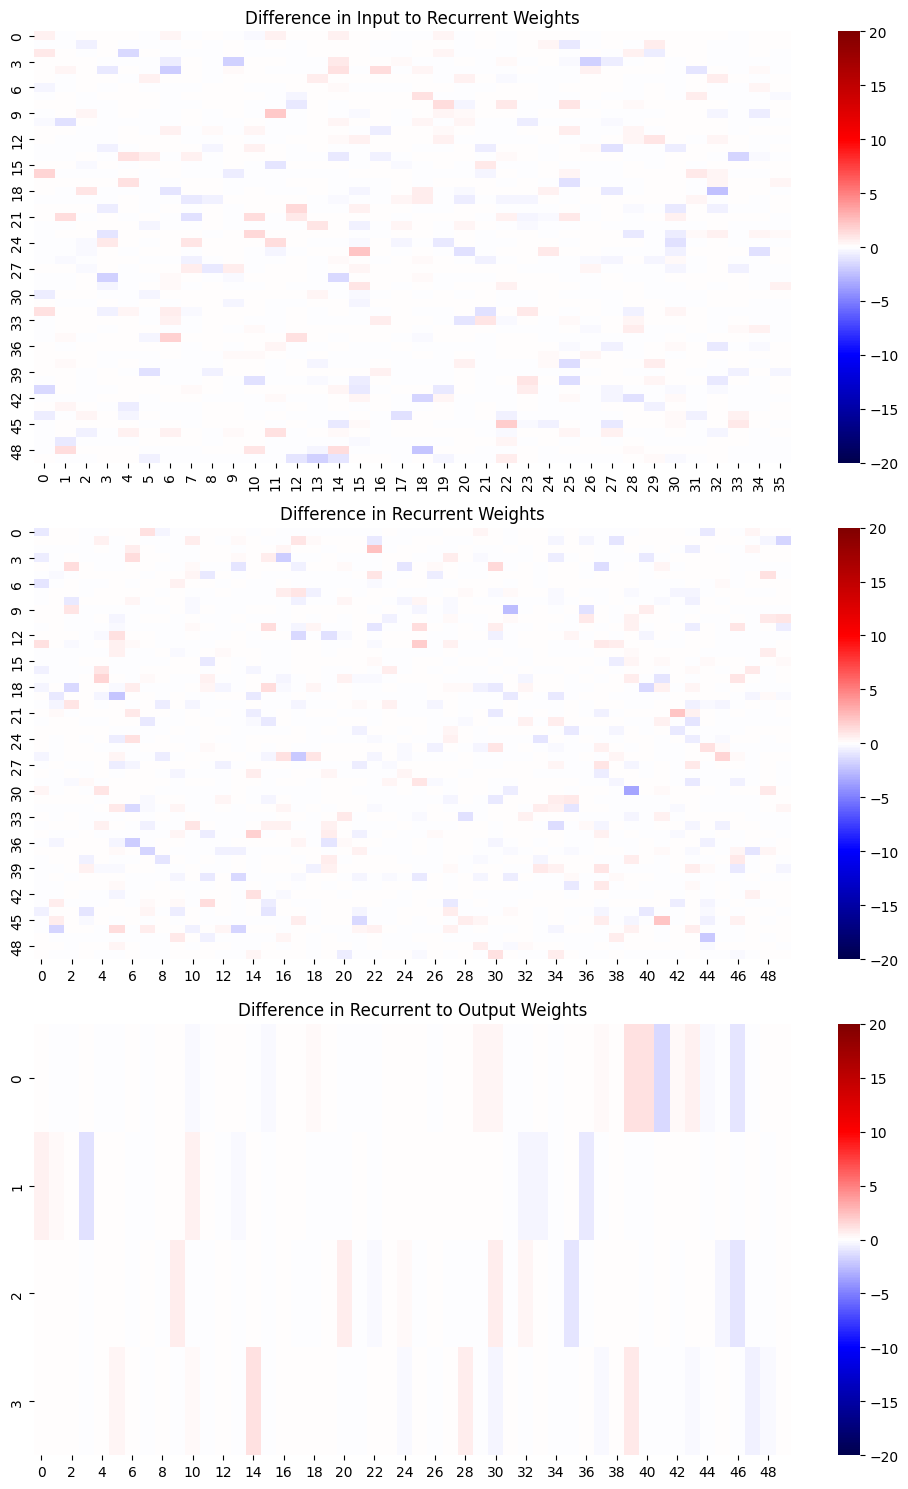

In [58]:
# plot heatmap of weight changes from initial to best model for each layer
def plot_connectivity_changes(initial_models, final_models):
    # Get average weights for initial and final models
    initial_avg_weights = get_layer_weights(initial_models)
    final_avg_weights = get_layer_weights(final_models)

    # Compute the differences
    weight_diffs = {
        'input_recurrent': final_avg_weights['input_recurrent'] - initial_avg_weights['input_recurrent'],
        'recurrent': final_avg_weights['recurrent'] - initial_avg_weights['recurrent'],
        'recurrent_output': final_avg_weights['recurrent_output'] - initial_avg_weights['recurrent_output']
    }

    # Plot heatmaps for each layer
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))
    
    sns.heatmap(weight_diffs['input_recurrent'], ax=axs[0], cmap="seismic", center=0, vmax=20, vmin=-20)
    axs[0].set_title('Difference in Input to Recurrent Weights')
    
    sns.heatmap(weight_diffs['recurrent'], ax=axs[1], cmap="seismic", center=0, vmax=20, vmin=-20)
    axs[1].set_title('Difference in Recurrent Weights')
    
    sns.heatmap(weight_diffs['recurrent_output'], ax=axs[2], cmap="seismic", center=0, vmax=20, vmin=-20)
    axs[2].set_title('Difference in Recurrent to Output Weights')
    
    plt.tight_layout()
    plt.show()

def get_layer_weights(models):
    layer_weights = {
        'input_recurrent': [],
        'recurrent': [],
        'recurrent_output': []
    }
    
    for model in models:
        input_recurrent_weights = model.l1.weight.data.cpu().numpy()
        recurrent_weights = model.rlif1.recurrent.weight.data.cpu().numpy()
        recurrent_output_weights = model.l2.weight.data.cpu().numpy()
    
        layer_weights['input_recurrent'].append(input_recurrent_weights)
        layer_weights['recurrent'].append(recurrent_weights)
        layer_weights['recurrent_output'].append(recurrent_output_weights)
    
    avg_weights = {
        'input_recurrent': np.mean(layer_weights['input_recurrent'], axis=0),
        'recurrent': np.mean(layer_weights['recurrent'], axis=0),
        'recurrent_output': np.mean(layer_weights['recurrent_output'], axis=0)
    }
    
    return avg_weights

best_perf = evolution.decode_population(evolution.encode_population([best_model]), best_model)

plot_connectivity_changes(initial_models, best_perf)

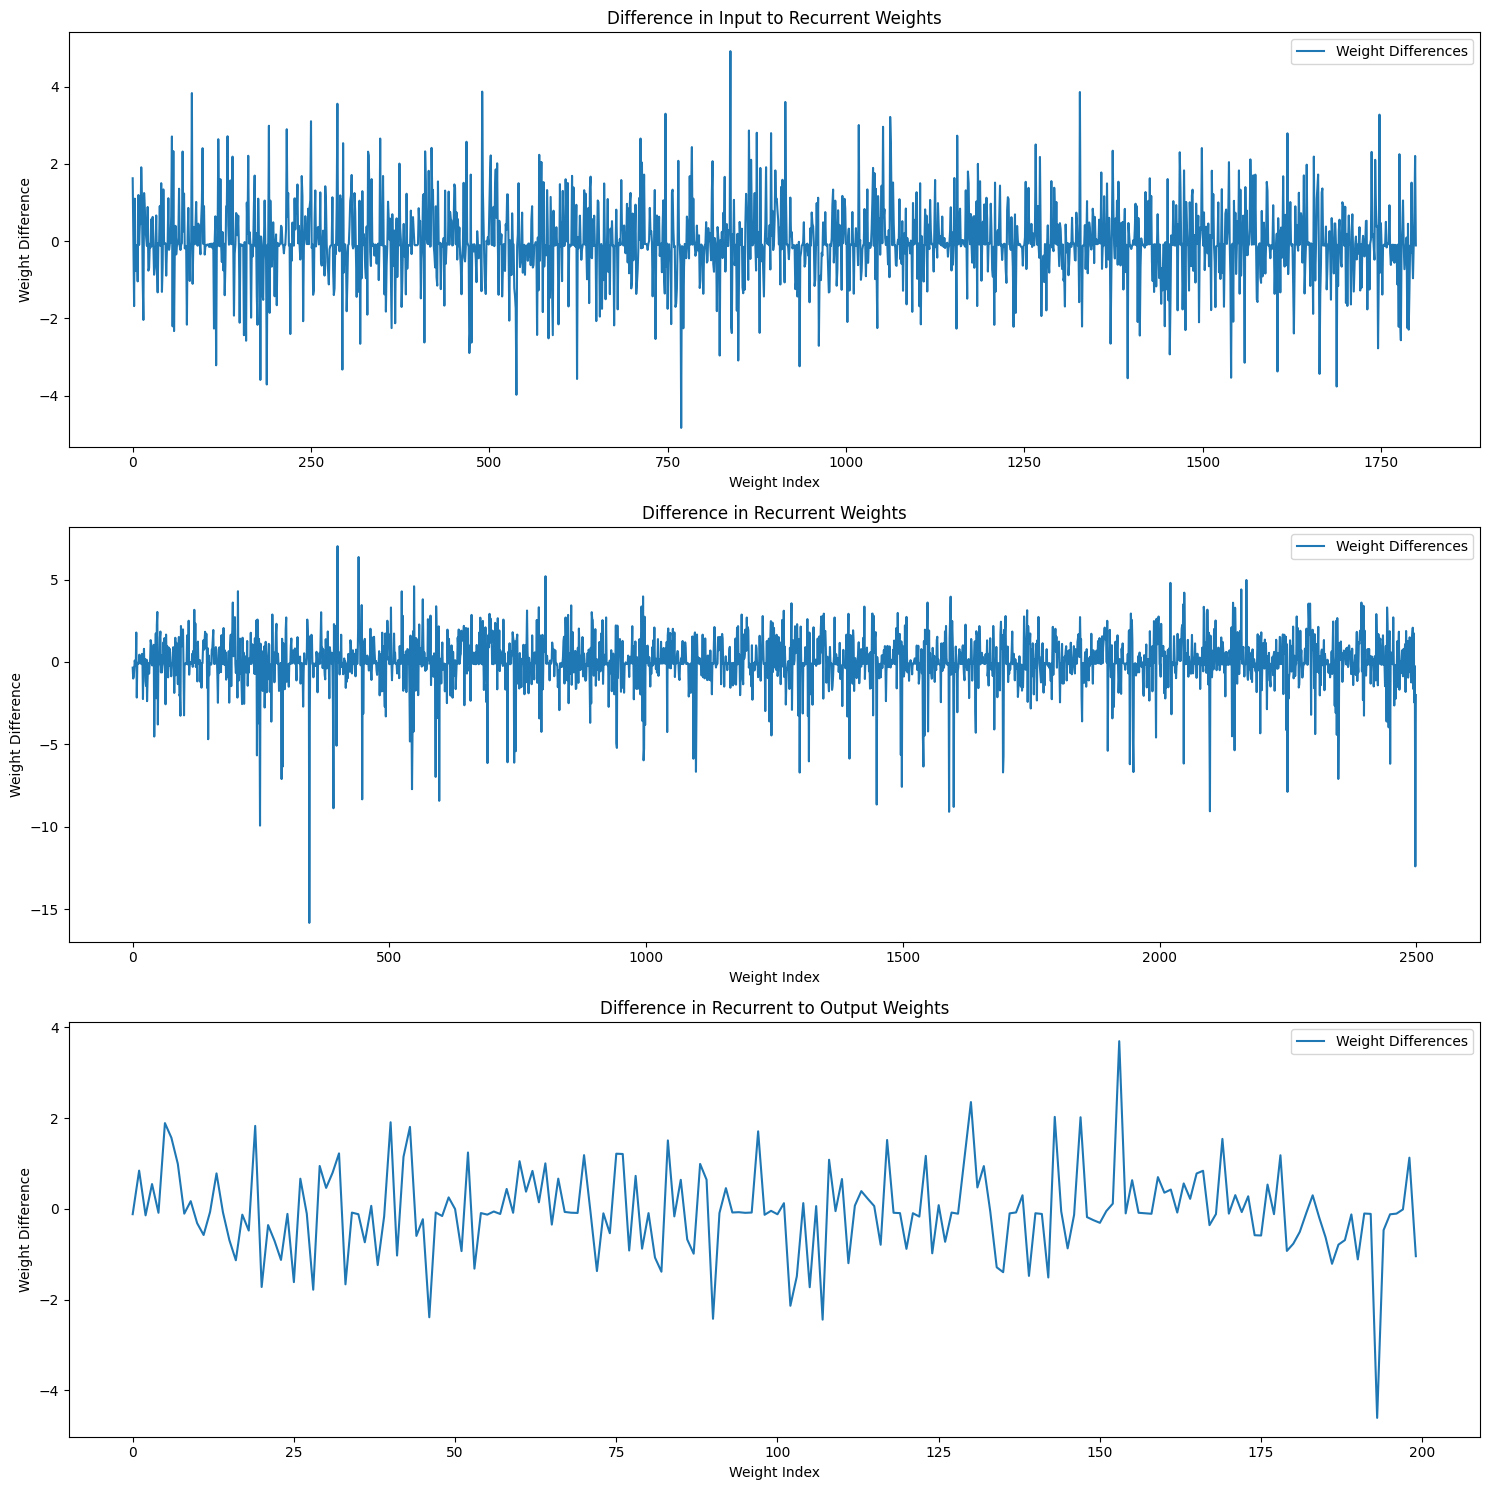

In [59]:
# line plot of the weight changes from initial to final models for each layer

def plot_connectivity_changes(initial_models, final_models):
    # Get average weights for initial and final models
    initial_avg_weights = get_layer_weights(initial_models)
    final_avg_weights = get_layer_weights(final_models)

    # Compute the differences
    weight_diffs = {
        'input_recurrent': final_avg_weights['input_recurrent'] - initial_avg_weights['input_recurrent'],
        'recurrent': final_avg_weights['recurrent'] - initial_avg_weights['recurrent'],
        'recurrent_output': final_avg_weights['recurrent_output'] - initial_avg_weights['recurrent_output']
    }

    # Plot the differences for each layer
    fig, axs = plt.subplots(3, 1, figsize=(15, 15))

    
    # Input to recurrent layer weights differences
    axs[0].plot(weight_diffs['input_recurrent'].flatten(), label='Weight Differences')
    axs[0].set_title('Difference in Input to Recurrent Weights')
    axs[0].set_xlabel('Weight Index')
    axs[0].set_ylabel('Weight Difference')
    axs[0].legend()

    
    # Recurrent layer weights differences
    axs[1].plot(weight_diffs['recurrent'].flatten(), label='Weight Differences')
    axs[1].set_title('Difference in Recurrent Weights')
    axs[1].set_xlabel('Weight Index')
    axs[1].set_ylabel('Weight Difference')
    axs[1].legend()
  
    
    # Recurrent to output layer weights differences
    axs[2].plot(weight_diffs['recurrent_output'].flatten(), label='Weight Differences')
    axs[2].set_title('Difference in Recurrent to Output Weights')
    axs[2].set_xlabel('Weight Index')
    axs[2].set_ylabel('Weight Difference')
    axs[2].legend()
    
  
    plt.tight_layout()
    plt.show()


final_models = evolution.decode_population(evolution.encode_population([best_model]), best_model)

plot_connectivity_changes(initial_models, final_models)